**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

*All the text in italics is instructions for filling the template - remove when writing the project report!*

# *Title* 

*Title should be concise and informative, describes the approach to solve the problem. Some good titles from previous years:*

*- Comparing extreme learning machines and naive bayes’ classifier in spam detection*

*- Using linear discriminant analysis in spam detection*

*Some not-so-good titles:*

*- Bayesian spam filtering with extras*

*- Two-component classifier for spam detection*

*- CS-E3210 Term Project, final report*




## Abstract

*Precise summary of the whole report, previews the contents and results. Must be a single paragraph between 100 and 200 words.*



## 1. Introduction

*Background, problem statement, motivation, many references, description of
contents. Introduces the reader to the topic and the broad context within which your
research/project fits*

*- What do you hope to learn from the project?*
*- What question is being addressed?*
*- Why is this task important? (motivation)*

*Keep it short (half to 1 page).*



## 2. Data analysis

*Briefly describe data (class distribution, dimensionality) and how will it affect
classification. Visualize the data. Don’t focus too much on the meaning of the features,
unless you want to.*

*- Include histograms showing class distribution.*




In [132]:
'''
Dependencies
'''
# Import dependencies
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn import metrics as met
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split as TTSplit
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report as ClassRep
from sklearn.metrics import confusion_matrix as ConfMat
from sklearn.linear_model import Perceptron, LogisticRegression as LogReg
from sklearn import preprocessing, svm, ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [133]:
'''
The utility functions used throughout the project
'''

# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
# Modified a bit
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues,
                          print_matrix = False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize = True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision = 2)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        if print_matrix: print("Normalized confusion matrix")
    else:
        if print_matrix: print('Confusion matrix, without normalization')

    if print_matrix: print(cm)

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Write results to excel files for analysis
def output(acc, logloss, name):
    # Check input
    if (acc.shape != (6544,)) or (logloss.shape != (6544, 10)):
        print('wrong input shapes')
        return
    
    df_acc = pd.DataFrame(acc, index = pd.Series(range(1, 6545), name = 'Sample_id'), columns = ['Sample_label'])
    df_logloss = pd.DataFrame(logloss, index = pd.Series(range(1, 6545), name = 'Sample_id'), 
        columns = ['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 
                   'Class_8', 'Class_9', 'Class_10'])
    
    # Excel file for analysis
    writer = pd.ExcelWriter(name+'.xlsx', engine = 'xlsxwriter')
    df_acc.to_excel(writer, sheet_name = 'accuracy')
    df_logloss.to_excel(writer, sheet_name = 'logloss')
    writer.save()
    
    # Kaggle submissions
    df_acc.to_csv(name+'_acc.csv')
    df_logloss.to_csv(name+'_logloss.csv')

# Compute PCA
def compute_pca(Z, d):
    # Input: the N by D data matrix Z, the number of components d
    # Output: a d by D matrix W_pca, and all eigenvalues of Q
    
    # step1: compute the sample cov. matrix Q
    Q = Z.T.dot(Z) / Z.shape[0]

    #step2: compute the eigenvalues and eigenvectors (see introduction notebook)
    eigvalues, eigvectors = np.linalg.eig(Q)
    eigvectors = eigvectors.T
    
    #step3: Sort the eigenvectors by decreasing eigenvalues, choose the d largest eigenvalues, form W_pca
    W_pca = np.asarray([x for _, x in sorted(zip(eigvalues,eigvectors), key = lambda pair: -pair[0].real)][:d])
    
    return W_pca.real, eigvalues

# Visualize PCA error
def plot_error(eigvalues, max_d):
    x = range(1, max_d + 1)
    errors = [sum(eigvalues[d:]) for d in x]
    plt.plot(x, errors)
    plt.xlabel('Principal Components $d$')
    plt.ylabel('Reconstruction error $\mathcal{E}$')
    plt.title('Principal Components vs. the Reconstruction Error')
    plt.show()
    

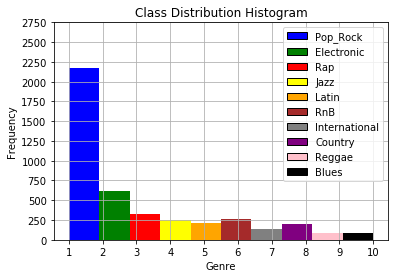

In [134]:
'''
Data Import from Files
'''

# Reading Data into Numpy Arrays
XTrainData = pd.read_csv("train_data.csv", header = None).values
YTrainData = pd.read_csv("train_labels.csv", header = None).values
XTestData = pd.read_csv("test_data.csv", header = None).values

# Storing Numpy Arrays into DataFrames for better visualization
FeatureTrainData = pd.DataFrame(XTrainData)
LabelTrainData = pd.DataFrame(YTrainData)
FeatureTestData = pd.DataFrame(XTestData)

#FeatureTrainData.head()
#FeatureTestData.head()
#LabelTrainData.head()

# Class Distribution Histogram 
fig, ax = plt.subplots()
N, bins, patches = ax.hist(YTrainData, linewidth = 2)
plt.title("Class Distribution Histogram")
plt.xlabel("Genre")
plt.ylabel("Frequency")
plt.grid(True)
plt.xticks(np.arange(1, 11, step = 1))
plt.yticks(np.arange(0, 3000, step = 250))
colors = ['blue', 'green', 'red', 'yellow', 'orange', 'brown', 'gray', 'purple', 'pink', 'black']
for i in range(0, 10):
    patches[i].set_facecolor(colors[i])
# Histogram Legend
handles = [Rectangle((0, 0), 1, 1, color = c, ec = "k") for c in colors]
labels = ["Pop_Rock", "Electronic", "Rap", "Jazz", "Latin", "RnB", "International", "Country", "Reggae", "Blues"]
plt.legend(handles, labels)
plt.show()

In [135]:
'''
Data Normalization (Choose one and comment out the others for testing)
'''

# Initialization of Scalers/Transformers/Normalizers
standard_scaler = preprocessing.StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler()
robust_scaler = preprocessing.RobustScaler()
normalize = preprocessing.Normalizer()
quantile_transformer = preprocessing.QuantileTransformer(random_state = 0)


# Choice of Scaling/Transforming/Normalizing (Default = Standard Scaler)
choice = 1

if choice == 1: 
    # Normalize the data with standard
    XTrainData = standard_scaler.fit_transform(XTrainData)
    XTestData = standard_scaler.fit_transform(XTestData)
elif choice == 2:
    # Normalize the data with minmax
    XTrainData = min_max_scaler.fit_transform(XTrainData)
    XTestData = min_max_scaler.fit_transform(XTestData)
elif choice == 3:
    # Normalize the data with robust scaler
    XTrainData = robust_scaler.fit_transform(XTrainData)
    XTestData = robust_scaler.fit_transform(XTestData)
elif choice == 4:
    #Normalize the data with Normalize
    XTrainData = normalize.fit_transform(XTrainData)
    XTestData = normalize.fit_transform(XTestData)
else:
    # Scale data onto Uniform Distribution [0, 1]
    XTrainData = quantile_transformer.fit_transform(XTrainData)
    XTestData = quantile_transformer.fit_transform(XTestData)

'''
Data Splits (Test and Train Sets)
'''

# Multiple split ratios for test purposes 
splitRatios = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85]

# Splitting the Test Data into Training and Testing Sets (both Features and Labels) (Normal)
XTrainSet, XTestSet, YTrainSet, YTestSet = TTSplit(XTrainData, YTrainData, test_size = splitRatios[2])

# Get label train and test set sizes for reshaping
Test_LabelSet_Size = len(YTestSet)
Train_LabelSet_Size = len(YTrainSet)

# Reshaping and preparing the training and testing sets. (R put with variable name (R = Refined)) 
# (Just re-shaped for now. To be refined later)
YTestR = np.reshape(YTestSet, (Test_LabelSet_Size, 1))
YTrainR = np.reshape(YTrainSet, (Train_LabelSet_Size, 1))

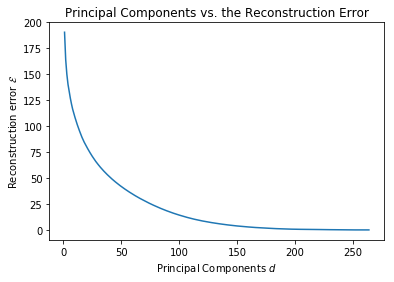

In [136]:
# Data has 264 features, calculate PCA and eigenvalues up to a full reconstruction
PCA, eigvalues = compute_pca(XTrainData, 264)

# plot the number of principal components vs the reconstruction error
plot_error(eigvalues, 264)

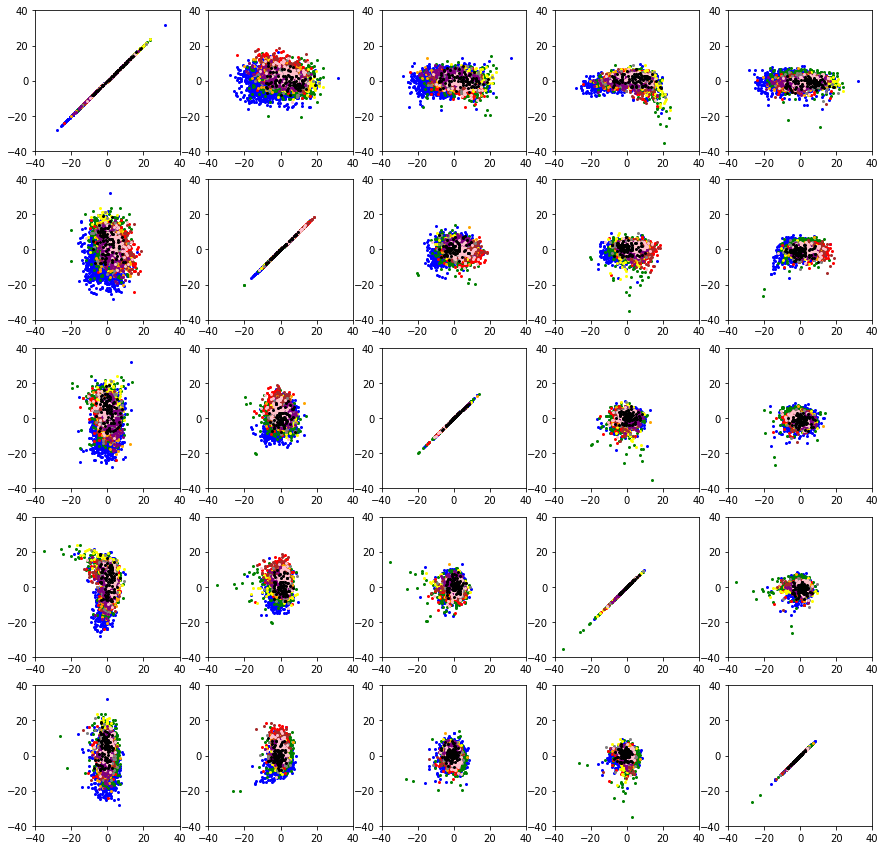

In [137]:
def plot_scatter(PCA, Z, Y):
    # get x for d = 10
    X_10d = np.matmul(PCA[:10, :], Z[:, :, None])[:, :, 0]
    colors = ['blue', 'green', 'red', 'yellow', 'orange', 'brown', 'gray', 'purple', 'pink', 'black']
    fig, axes = plt.subplots(5, 5)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i in range(5):
        for j in range(5):
            for class_id in range(len(labels)):
                axes[i, j].scatter(X_10d[np.where(Y == class_id + 1),i], X_10d[np.where(Y == class_id + 1),j],
                                   marker = 'o', s = 4, c = colors[class_id], label = labels[i])
                #axes[i,j].legend()
                axes[i, j].set_xlim([-40, 40])
                axes[i, j].set_ylim([-40, 40])
    # Set common labels
    plt.show()
    

plot_scatter(PCA, XTrainData, YTrainData)

In [117]:
''' 
Multinomial Logistic Regression with Multiple Iterations
PARAMETERS:
    Iterations = 7500
    Inverse Regularization Constant = 0.1 till 10
    Solver = SAG
    Penalty = L2
'''

C = 0.001
testAcc = []
validAcc = []
validLogloss = []
C_array = []

while C < 0.1:
    logreg = LogReg(C = C, max_iter = 7500, solver ='sag', multi_class = 'multinomial', n_jobs = -2)

    # Fitting the refined training sets 
    logreg.fit(XTrainSet, YTrainR.ravel())

    # Calculation of training accuracy
    predictTest = logreg.predict(XTestSet)
    predictTrain = logreg.predict(XTrainSet)

    # Display the calculated accuracies
    print('Inverse of Regularization Constant (C): ', C)
    print('Training Accuracy: ', met.accuracy_score(predictTrain, YTrainR))
    print('Testing Accuracy: ', met.accuracy_score(predictTest, YTestR))
    testAcc.append(met.accuracy_score(predictTrain, YTrainR))
    validAcc.append(met.accuracy_score(predictTest, YTestR))
    validLogloss.append(met.log_loss(YTestR, logreg.predict_proba(XTestSet)))
    C_array.append(C)
    
    # Display final score from Logistic Regression
    score = logreg.score(XTestSet, YTestSet)
    print('Final Score: ', score, '\n')
    
    # Increment C for next iteration
    C = C * 1.2


Inverse of Regularization Constant (C):  0.001
Training Accuracy:  0.6207951070336392
Testing Accuracy:  0.5842880523731587
Final Score:  0.5842880523731587 

Inverse of Regularization Constant (C):  0.0012
Training Accuracy:  0.6276758409785933
Testing Accuracy:  0.5888707037643208
Final Score:  0.5888707037643208 

Inverse of Regularization Constant (C):  0.0014399999999999999
Training Accuracy:  0.6345565749235474
Testing Accuracy:  0.5905073649754501
Final Score:  0.5905073649754501 

Inverse of Regularization Constant (C):  0.0017279999999999997
Training Accuracy:  0.6429663608562691
Testing Accuracy:  0.5944353518821603
Final Score:  0.5944353518821603 

Inverse of Regularization Constant (C):  0.0020735999999999997
Training Accuracy:  0.6529051987767585
Testing Accuracy:  0.5993453355155482
Final Score:  0.5993453355155482 

Inverse of Regularization Constant (C):  0.0024883199999999996
Training Accuracy:  0.6620795107033639
Testing Accuracy:  0.6032733224222586
Final Score:  0.

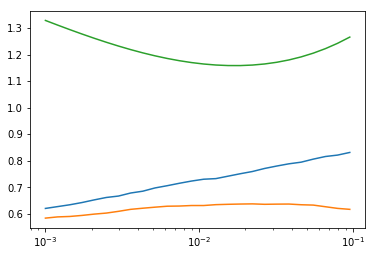

In [118]:
'''
Accuracy Plot for multiple Multinomial Logistic Regression Classifications
'''
plt.figure()
plt.plot(C_array,testAcc)
plt.plot(C_array,validAcc)
plt.plot(C_array,validLogloss)
plt.xscale('log')
plt.show()

In [ ]:
# Trial runs of all relevant Classifiers on the data (for test purposes)

''' 
Gradient Boosting Classifier on the data
    Default Settings
'''

'''
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(XTrainSet, YTrainR.ravel())
predictTest = gbc.predict(XTestSet)
predictTrain = gbc.predict(XTrainSet)
score = gbc.score(XTestSet, YTestSet)
print('Training Accuracy: ', met.accuracy_score(predictTrain, YTrainR))
print('Testing Accuracy: ', met.accuracy_score(predictTest, YTestR))
print('Final Score: ', score, '\n')
'''



''' 
Random Forest Classifier on the data
    Default Settings
'''
'''
rfc = ensemble.RandomForestClassifier()
rfc.fit(XTrainSet, YTrainR.ravel())
predictTest = rfc.predict(XTestSet)
predictTrain = rfc.predict(XTrainSet)
score = rfc.score(XTestSet, YTestSet)
print('Training Accuracy: ', met.accuracy_score(predictTrain, YTrainR))
print('Testing Accuracy: ', met.accuracy_score(predictTest, YTestR))
print('Final Score: ', score, '\n')
'''


''' 
RBF SVM Classifier on the data
    Default Settings
'''

'''
rbfsvm = svm.SVC()
rbfsvm.fit(XTrainSet, YTrainR.ravel())
predictTest = rbfsvm.predict(XTestSet)
predictTrain = rbfsvm.predict(XTrainSet)
score = rbfsvm.score(XTestSet, YTestSet)
print('Training Accuracy: ', met.accuracy_score(predictTrain, YTrainR))
print('Testing Accuracy: ', met.accuracy_score(predictTest, YTestR))
print('Final Score: ', score, '\n')
'''

In [128]:
# For this part, only run the first 3 windows...
'''
Stratified K-Fold Validation to Improve Classifier Scores
'''

XTrainData = min_max_scaler.fit_transform(XTrainData)
XTestData = min_max_scaler.fit_transform(XTestData)
bestAcc = 0
skf = StratifiedKFold(n_splits = 10, random_state = 17)
for train_index, test_index in skf.split(XTrainData, YTrainData): 
    XTrainSet, XTestSet = XTrainData[train_index], XTrainData[test_index] 
    YTrainSet, YTestSet = YTrainData[train_index], YTrainData[test_index]
    logreg = LogReg(C = 1.6, max_iter = 5000, solver ='sag', multi_class = 'multinomial')
    logreg.fit(XTrainSet, YTrainSet.ravel())
    predictTrain = logreg.predict(XTrainSet)
    print('Validation Accuracy: ', met.accuracy_score(YTestSet, logreg.predict(XTestSet)))
    print('Validation Log-loss: ', met.log_loss(YTestSet, logreg.predict_proba(XTestSet)), '\n')
    if met.accuracy_score(YTestSet, logreg.predict(XTestSet)) > bestAcc:
        train_idx = train_index
        test_idx = test_index
        bestAcc = met.accuracy_score(YTestSet, logreg.predict(XTestSet))

Validation Accuracy:  0.655328798185941
Validation Log-loss:  1.0396288411766017 

Validation Accuracy:  0.6568181818181819
Validation Log-loss:  1.0686624987701705 

Validation Accuracy:  0.6674259681093394
Validation Log-loss:  1.0532605302575158 

Validation Accuracy:  0.678082191780822
Validation Log-loss:  1.0366795860318303 

Validation Accuracy:  0.6544622425629291
Validation Log-loss:  1.08132247592422 

Validation Accuracy:  0.6444954128440367
Validation Log-loss:  1.1228822853438634 

Validation Accuracy:  0.6751152073732719
Validation Log-loss:  1.1074628713426846 

Validation Accuracy:  0.6728110599078341
Validation Log-loss:  0.9967588438948681 

Validation Accuracy:  0.6620370370370371
Validation Log-loss:  0.9917767265906795 

Validation Accuracy:  0.6458333333333334
Validation Log-loss:  1.1659972298031522 



In [129]:
XTrainSet, XTestSet = XTrainData[train_idx], XTrainData[test_idx] 
YTrainSet, YTestSet = YTrainData[train_idx], YTrainData[test_idx]
logreg = LogReg(C = 1.6, max_iter = 5000, solver ='sag', multi_class = 'multinomial')
logreg.fit(XTrainSet, YTrainSet.ravel())
predictTrain = logreg.predict(XTrainSet)
print('Validation Accuracy: ', met.accuracy_score(YTestSet, logreg.predict(XTestSet)))
print('Validation Log-loss: ', met.log_loss(YTestSet, logreg.predict_proba(XTestSet)), '\n')

Validation Accuracy:  0.678082191780822
Validation Log-loss:  1.0366731712794772 



In [21]:
'''
Single Multinomial Logistic Regression Classification
'''

logreg = LogReg(C = 0.03, max_iter = 7500, solver ='sag', multi_class = 'multinomial', n_jobs = -2)
logreg.fit(XTrainSet, YTrainSet.ravel())
predictTrain = logreg.predict(XTrainSet)
print('Validation Accuracy: ', met.accuracy_score(YTestSet, logreg.predict(XTestSet)))
print('Validation Log-loss: ', met.log_loss(YTestSet, logreg.predict_proba(XTestSet)))

Validation Accuracy:  0.625531914893617
Validation Log-loss:  1.2033487262784646


In [130]:
# Output demo
output(logreg.predict(XTestData).ravel(),logreg.predict_proba(XTestData),'logreg')

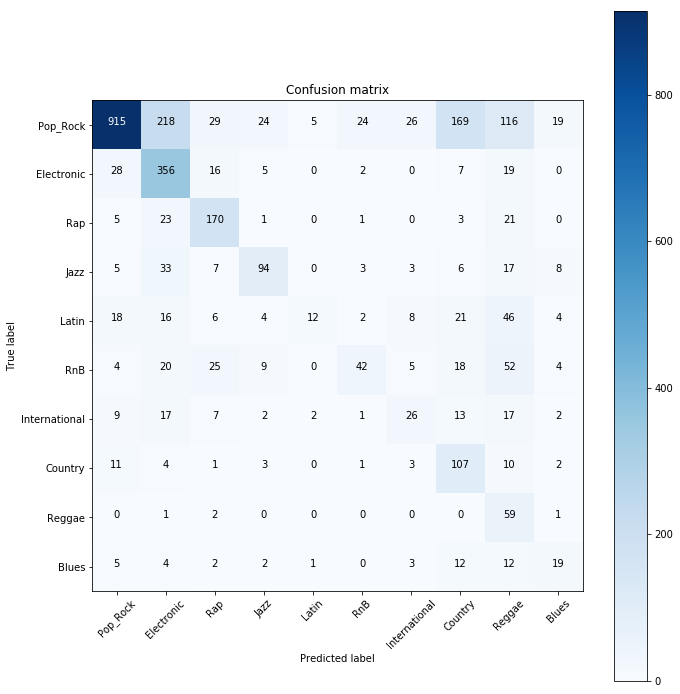

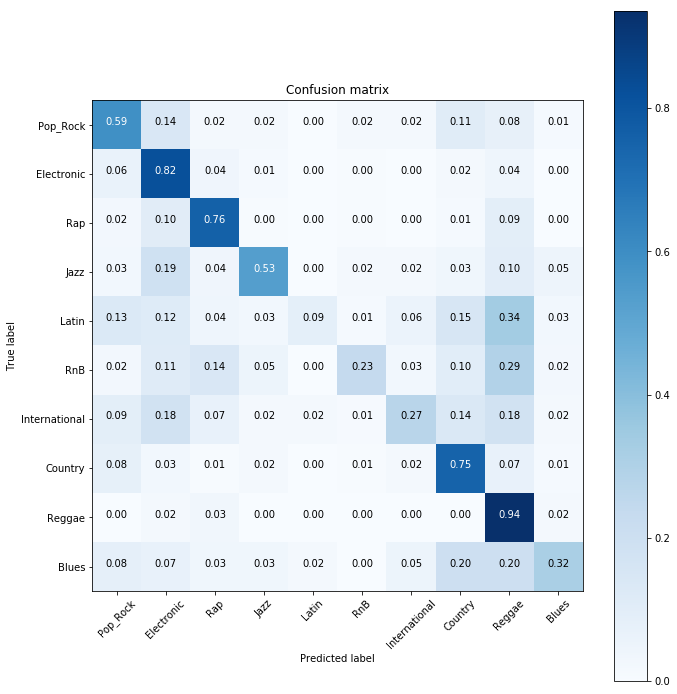

In [138]:
# Confusion matrix demo
class_names = ['Pop_Rock','Electronic','Rap','Jazz','Latin','RnB','International','Country','Reggae','Blues']
plt.figure(figsize = (10,10))
plot_confusion_matrix(YTestSet, logreg.predict(XTestSet), classes = class_names, normalize = False)
plt.figure(figsize = (10,10))
plot_confusion_matrix(YTestSet, logreg.predict(XTestSet), classes = class_names, normalize = True)

In [24]:
''' 
KNN Classifier Testing with Mutiple Iterations
'''

k_array = []
acc = []
for k in range(50):
    neigh = KNeighborsClassifier(n_neighbors=k+1, n_jobs = -2)
    neigh.fit(XTrainSet, YTrainSet.ravel())
    predLabels = neigh.predict(XTestSet)
    conf = confusion_matrix(YTestSet, predLabels)
    accuracy = np.trace(conf)/np.sum(conf)
    k_array.append(k+1)
    acc.append(accuracy)
    print('Accuracy:', accuracy,'with', k+1, 'neighbors')


Accuracy: 0.4595744680851064 with 1 neighbors
Accuracy: 0.5253682487725041 with 2 neighbors
Accuracy: 0.5410801963993453 with 3 neighbors
Accuracy: 0.5391162029459902 with 4 neighbors
Accuracy: 0.5499181669394435 with 5 neighbors
Accuracy: 0.5561374795417349 with 6 neighbors
Accuracy: 0.5551554828150573 with 7 neighbors
Accuracy: 0.5590834697217676 with 8 neighbors
Accuracy: 0.5613747954173486 with 9 neighbors
Accuracy: 0.5623567921440262 with 10 neighbors
Accuracy: 0.5666121112929624 with 11 neighbors
Accuracy: 0.5646481178396072 with 12 neighbors
Accuracy: 0.5636661211129296 with 13 neighbors
Accuracy: 0.565302782324059 with 14 neighbors
Accuracy: 0.5636661211129296 with 15 neighbors
Accuracy: 0.5623567921440262 with 16 neighbors
Accuracy: 0.5610474631751228 with 17 neighbors
Accuracy: 0.5587561374795418 with 18 neighbors
Accuracy: 0.5574468085106383 with 19 neighbors
Accuracy: 0.5567921440261866 with 20 neighbors
Accuracy: 0.560392798690671 with 21 neighbors
Accuracy: 0.558101472995

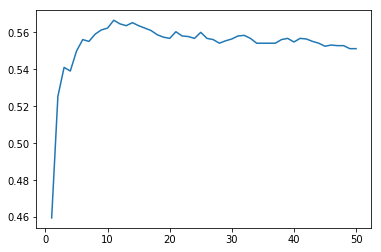

In [25]:
'''
Accuracy Plot for multiple KNN Classifications
'''

plt.figure()
plt.plot(k_array, acc)
plt.show()

In [ ]:
'''
Single KNN Classification
'''

neigh = KNeighborsClassifier(n_neighbors=20, n_jobs = -2)
neigh.fit(XTrainSet, YTrainSet.ravel())
predLabels = neigh.predict(XTestSet)
conf = confusion_matrix(YTestSet, predLabels)
accuracy = np.trace(conf)/np.sum(conf)
print('Accuracy:', accuracy)
logloss = neigh.predict_proba(XTestSet)

In [140]:
clf = Perceptron(random_state=0)
clf.fit(XTrainSet, YTrainSet.ravel())
print(clf.score(XTrainSet, YTrainSet.ravel()))
print(clf.score(XTestSet, YTestSet.ravel()))

0.7377675840978594
0.5145662847790508


In [ ]:
# Load the data and cleanup

In [ ]:
#Analysis of the input data
# ...

## 3. Methods and experiments

*- Explain your whole approach (you can include a block diagram showing the steps in your process).* 

*- What methods/algorithms, why were the methods chosen. *

*- What evaluation methodology (cross CV, etc.).*



In [ ]:
# Trials with ML algorithms

## 4. Results

*Summarize the results of the experiments without discussing their implications.*

*- Include both performance measures (accuracy and LogLoss).*

*- How does it perform on kaggle compared to the train data.*

*- Include a confusion matrix.*



In [ ]:
#Confusion matrix ...

## 5. Discussion/Conclusions

*Interpret and explain your results *

*- Discuss the relevance of the performance measures (accuracy and LogLoss) for
imbalanced multiclass datasets. *

*- How the results relate to the literature. *

*- Suggestions for future research/improvement. *

*- Did the study answer your questions? *



## 6. References

*List of all the references cited in the document*

## Appendix
*Any additional material needed to complete the report can be included here. For example, if you want to keep  additional source code, additional images or plots, mathematical derivations, etc. The content should be relevant to the report and should help explain or visualize something mentioned earlier. **You can remove the whole Appendix section if there is no need for it.** *